In [1]:
# Import necessary packages
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from hy2dl.evaluation.metrics import nse

color_palette = {"LSTM": "#4daf4a", "benchmark": "#377eb8", "MTS": "#ff7f00", "sMTS": "#984ea3"}

Part 1. Benchmark CAMELS_GB.


Lees, T., Buechel, M., Anderson, B., Slater, L., Reece, S., Coxon, G., & Dadson, S. J. (2021). Benchmarking data-driven rainfall–runoff models in Great Britain: A comparison of long short-term memory (LSTM)-based models with four lumped conceptual models. Hydrology and Earth System Sciences, 25(10), 5517–5534. https://doi.org/10.5194/hess-25-5517-2021

In [ ]:
# Read the results generated by Lees et al. (2021)
path_results_less = "Lees2021/metrics.nc"
lees_metrics = xr.open_dataset(path_results_less)
df_NSE_less = lees_metrics.sel(model="LSTM")["nse"].to_pandas()
df_NSE_less = df_NSE_less.to_frame(name="Benchmark_Lees")
df_NSE_less.index = df_NSE_less.index.astype(str)
df_NSE_less.index.name = "basin_id"

In [6]:
# Read the results generated using Hy2DL
path_results_LSTM = ["LSTM_CAMELS_GB_seed_1", "LSTM_CAMELS_GB_seed_2", "LSTM_CAMELS_GB_seed_3", "LSTM_CAMELS_GB_seed_4"]

# Create ensemble
lstm_results = {}
for i, ensemble_member in enumerate(path_results_LSTM):
    with open(ensemble_member + "/test_results.pickle", "rb") as f:
        info_lstm = pickle.load(f)
    # Iterate over each basin
    for basin in info_lstm.keys():
        y_sim = info_lstm[basin]["y_sim"]
        if i == 0:  # If this is the first ensemble member, initialize the DataFrame with y_obs and y_sim
            y_obs = info_lstm[basin]["y_obs"]
            lstm_results[basin] = pd.DataFrame(data={"y_obs": y_obs, f"y_sim_ens_{i + 1}": y_sim}, index=y_obs.index)
        else:  # For subsequent ensemble members, add y_sim as a new column
            lstm_results[basin][f"y_sim_ens_{i + 1}"] = y_sim

# Calculate the median of the simulated values and add it as a new column
for basin in lstm_results.keys():
    # Select only the y_sim columns
    y_sim_columns = [col for col in lstm_results[basin].columns if col.startswith("y_sim_ens_")]
    lstm_results[basin]["y_sim"] = lstm_results[basin][y_sim_columns].median(axis=1)

df_NSE_CAMELS_GB = pd.DataFrame(
    data={"basin_id": list(lstm_results.keys()), "LSTM": np.round(nse(df_results=lstm_results, average=False), 3)}
).set_index("basin_id")

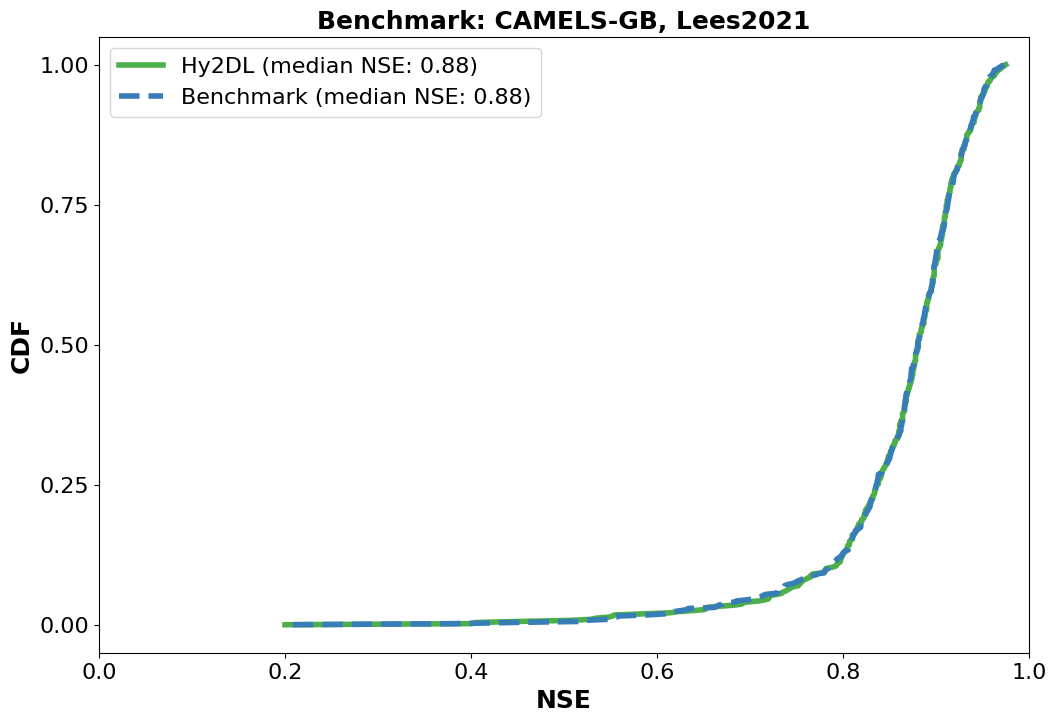

In [7]:
df_NSE_comparison = pd.concat([df_NSE_CAMELS_GB, df_NSE_less], axis=1)
df_NSE_comparison = df_NSE_comparison.apply(lambda x: x.sort_values().values).reset_index(drop=True)
df_NSE_comparison["cdf"] = np.arange(len(df_NSE_comparison)) / (len(df_NSE_comparison) - 1)

# Create plot
plt.rcParams["figure.figsize"] = (12, 8)

plt.plot(
    df_NSE_comparison["LSTM"],
    df_NSE_comparison["cdf"],
    linewidth=4,
    label=f"Hy2DL (median NSE: {df_NSE_comparison['LSTM'].median():.2f})",
    color=color_palette["LSTM"],
)
plt.plot(
    df_NSE_comparison["Benchmark_Lees"],
    df_NSE_comparison["cdf"],
    linewidth=4,
    linestyle="--",
    label=f"Benchmark (median NSE: {df_NSE_comparison['Benchmark_Lees'].median():.2f})",
    color=color_palette["benchmark"],
)


plt.xlim(0, 1)
plt.xlabel("NSE", fontsize=18, fontweight="bold")
plt.ylabel("CDF", fontsize=18, fontweight="bold")
plt.xticks(fontsize=16)
plt.yticks([i * 0.25 for i in range(5)], fontsize=16)

plt.legend(loc="upper left", fontsize=16)
plt.title("Benchmark: CAMELS-GB, Lees2021", fontsize=18, fontweight="bold")
plt.savefig("Benchmark_Lees2021.png", bbox_inches="tight", pad_inches=0.1, dpi=300)
plt.show()

Part 2. Benchmark CAMELS_US.

Kratzert, F., Klotz, D., Shalev, G., Klambauer, G., Hochreiter, S., & Nearing, G. (2019). Towards learning universal, regional, and local hydrological behaviors via machine learning applied to large-sample datasets. Hydrology and Earth System Sciences, 23(12), 5089–5110. https://doi.org/10.5194/hess-23-5089-2019

In [4]:
# Read the results generated by Kratzert et al. (2019)
path_results_kratzert = "Kratzert2019/all_metrics.p"
with open(path_results_kratzert, "rb") as f:
    kratzert_metrics = pickle.load(f)
df_NSE_Kratzert = pd.DataFrame(
    list(kratzert_metrics["NSE"]["lstm_NSE"]["ensemble"].items()), columns=["basin_id", "Benchmark_Kratzert"]
).set_index("basin_id")

In [5]:
# Read the results generated using Hy2DL
path_results_LSTM = ["LSTM_CAMELS_US_seed_111", "LSTM_CAMELS_US_seed_222", 
                     "LSTM_CAMELS_US_seed_333", "LSTM_CAMELS_US_seed_444"]

# Read information produced by ensemble of LSTMs and store it in dictionary of dataframes ----------------------------
lstm_results = {}
for i, ensemble_member in enumerate(path_results_LSTM):
    with open(ensemble_member + "/test_results.pickle", "rb") as f:
        info_lstm = pickle.load(f)
    # Iterate over each basin
    for basin in info_lstm.keys():
        y_sim = info_lstm[basin]["y_sim"]
        if i == 0:  # If this is the first ensemble member, initialize the DataFrame with y_obs and y_sim
            y_obs = info_lstm[basin]["y_obs"]
            lstm_results[basin] = pd.DataFrame(data={"y_obs": y_obs, f"y_sim_ens_{i + 1}": y_sim}, index=y_obs.index)
        else:  # For subsequent ensemble members, add y_sim as a new column
            lstm_results[basin][f"y_sim_ens_{i + 1}"] = y_sim

# Calculate the median of the simulated values and add it as a new column
for basin in lstm_results.keys():
    # Select only the y_sim columns
    y_sim_columns = [col for col in lstm_results[basin].columns if col.startswith("y_sim_ens_")]
    lstm_results[basin]["y_sim"] = lstm_results[basin][y_sim_columns].median(axis=1)

df_NSE_CAMELS_US = pd.DataFrame(
    data={"basin_id": list(lstm_results.keys()), "LSTM": np.round(nse(df_results=lstm_results, average=False), 3)}
).set_index("basin_id")

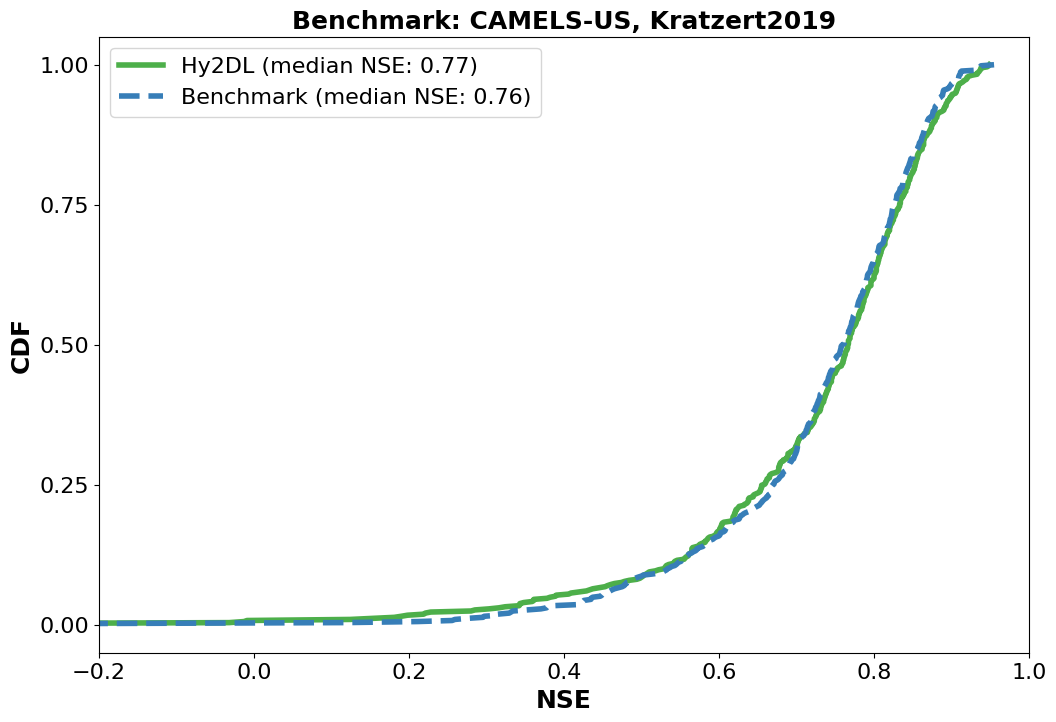

In [9]:
df_NSE_comparison = pd.concat([df_NSE_CAMELS_US, df_NSE_Kratzert], axis=1)
df_NSE_comparison = df_NSE_comparison.apply(lambda x: x.sort_values().values).reset_index(drop=True)
df_NSE_comparison["cdf"] = np.arange(len(df_NSE_comparison)) / (len(df_NSE_comparison) - 1)

# Create plot
plt.rcParams["figure.figsize"] = (12, 8)

plt.plot(
    df_NSE_comparison["LSTM"],
    df_NSE_comparison["cdf"],
    linewidth=4,
    label=f"Hy2DL (median NSE: {df_NSE_comparison['LSTM'].median():.2f})",
    color=color_palette["LSTM"],
)
plt.plot(
    df_NSE_comparison["Benchmark_Kratzert"],
    df_NSE_comparison["cdf"],
    linewidth=4,
    linestyle="--",
    label=f"Benchmark (median NSE: {df_NSE_comparison['Benchmark_Kratzert'].median():.2f})",
    color=color_palette["benchmark"],
)


plt.xlim(-0.2, 1)
plt.xlabel("NSE", fontsize=18, fontweight="bold")
plt.ylabel("CDF", fontsize=18, fontweight="bold")
plt.xticks(fontsize=16)
plt.yticks([i * 0.25 for i in range(5)], fontsize=16)

plt.legend(loc="upper left", fontsize=16)
plt.title("Benchmark: CAMELS-US, Kratzert2019", fontsize=18, fontweight="bold")
plt.savefig("Benchmark_Kratzert2019.png", bbox_inches="tight", pad_inches=0.1, dpi=300)
plt.show()

Part 3. Benchmark hourly CAMELS_US.

Gauch, M., Kratzert, F., Klotz, D., Nearing, G., Lin, J., & Hochreiter, S. (2021). Rainfall–runoff prediction at multiple timescales with a single Long Short-Term Memory network. Hydrology and Earth System Sciences, 25(4), 2045–2062. https://doi.org/10.5194/hess-25-2045-2021

In [2]:
# Read the results generated by Gauch et al. (2021)
df_NSE_MTS = pd.read_csv("Gauch2021/NSE_MTS_benchmark.csv", index_col="basin_id", dtype={"basin_id": str})
df_NSE_sMTS = pd.read_csv("Gauch2021/NSE_sMTS_benchmark.csv", index_col="basin_id", dtype={"basin_id": str})
df_NSE_Naive = pd.read_csv("Gauch2021/NSE_Naive_benchmark.csv", index_col="basin_id", dtype={"basin_id": str})

# Read the results generated by Gauch et al. (2021)
df_NSE_MTS_FreqPerVar = pd.read_csv(
    "Gauch2021/NSE_MTS_multipleforcing_benchmark.csv", index_col="basin_id", dtype={"basin_id": str}
)

In [5]:
# First experiment: Same number of inputs for daily and hourly data.
path_results_LSTM = [
    "camels_us_hourly_seed_110",
    "camels_us_hourly_seed_111",
    "camels_us_hourly_seed_222",
    "camels_us_hourly_seed_333",
]

# Read information produced by ensemble of LSTMs and store it in dictionary of dataframes ----------------------------
lstm_results = {}
for i, ensemble_member in enumerate(path_results_LSTM):
    with open(ensemble_member + "/test_results.pickle", "rb") as f:
        info_lstm = pickle.load(f)
    # Iterate over each basin
    for basin in info_lstm.keys():
        y_sim = info_lstm[basin]["y_sim"]
        if i == 0:  # If this is the first ensemble member, initialize the DataFrame with y_obs and y_sim
            y_obs = info_lstm[basin]["y_obs"]
            lstm_results[basin] = pd.DataFrame(data={"y_obs": y_obs, f"y_sim_ens_{i + 1}": y_sim}, index=y_obs.index)
        else:  # For subsequent ensemble members, add y_sim as a new column
            lstm_results[basin][f"y_sim_ens_{i + 1}"] = y_sim

# Calculate the median of the simulated values and add it as a new column
for basin in lstm_results.keys():
    # Select only the y_sim columns
    y_sim_columns = [col for col in lstm_results[basin].columns if col.startswith("y_sim_ens_")]
    lstm_results[basin]["y_sim"] = lstm_results[basin][y_sim_columns].median(axis=1)

df_NSE_lstm_CAMELS_US_hourly = pd.DataFrame(
    data={"basin_id": list(lstm_results.keys()), "LSTM": np.round(nse(df_results=lstm_results, average=False), 3)}
).set_index("basin_id")

df_NSE_comparison_exp1 = pd.concat([df_NSE_lstm_CAMELS_US_hourly, df_NSE_MTS, df_NSE_sMTS, df_NSE_Naive], axis=1)
df_NSE_comparison_exp1 = df_NSE_comparison_exp1.apply(lambda x: x.sort_values().values).reset_index(drop=True)
df_NSE_comparison_exp1["cdf"] = np.arange(len(df_NSE_comparison_exp1)) / (len(df_NSE_comparison_exp1) - 1)

In [6]:
# Second experiment: Different number of inputs for daily and hourly data.
path_results_LSTM = [
    "camels_us_hourly_ForcingsPerFreq_seed_110",
    "camels_us_hourly_ForcingsPerFreq_seed_111",
    "camels_us_hourly_ForcingsPerFreq_seed_222",
    "camels_us_hourly_ForcingsPerFreq_seed_333",
]

# Read information produced by ensemble of LSTMs and store it in dictionary of dataframes ----------------------------
lstm_results = {}
for i, ensemble_member in enumerate(path_results_LSTM):
    with open(ensemble_member + "/test_results.pickle", "rb") as f:
        info_lstm = pickle.load(f)
    # Iterate over each basin
    for basin in info_lstm.keys():
        y_sim = info_lstm[basin]["y_sim"]
        if i == 0:  # If this is the first ensemble member, initialize the DataFrame with y_obs and y_sim
            y_obs = info_lstm[basin]["y_obs"]
            lstm_results[basin] = pd.DataFrame(data={"y_obs": y_obs, f"y_sim_ens_{i + 1}": y_sim}, index=y_obs.index)
        else:  # For subsequent ensemble members, add y_sim as a new column
            lstm_results[basin][f"y_sim_ens_{i + 1}"] = y_sim
# Calculate the mean of the simulated values and add it as a new column
for basin in lstm_results.keys():
    # Select only the y_sim columns
    y_sim_columns = [col for col in lstm_results[basin].columns if col.startswith("y_sim_ens_")]
    lstm_results[basin]["y_sim"] = lstm_results[basin][y_sim_columns].median(axis=1)

df_NSE_lstm_CAMELS_US_hourly = pd.DataFrame(
    data={"basin_id": list(lstm_results.keys()), "LSTM": np.round(nse(df_results=lstm_results, average=False), 3)}
).set_index("basin_id")

df_NSE_comparison_exp2 = pd.concat([df_NSE_lstm_CAMELS_US_hourly, df_NSE_MTS_FreqPerVar], axis=1)
df_NSE_comparison_exp2 = df_NSE_comparison_exp2.apply(lambda x: x.sort_values().values).reset_index(drop=True)
df_NSE_comparison_exp2["cdf"] = np.arange(len(df_NSE_comparison_exp2)) / (len(df_NSE_comparison_exp2) - 1)

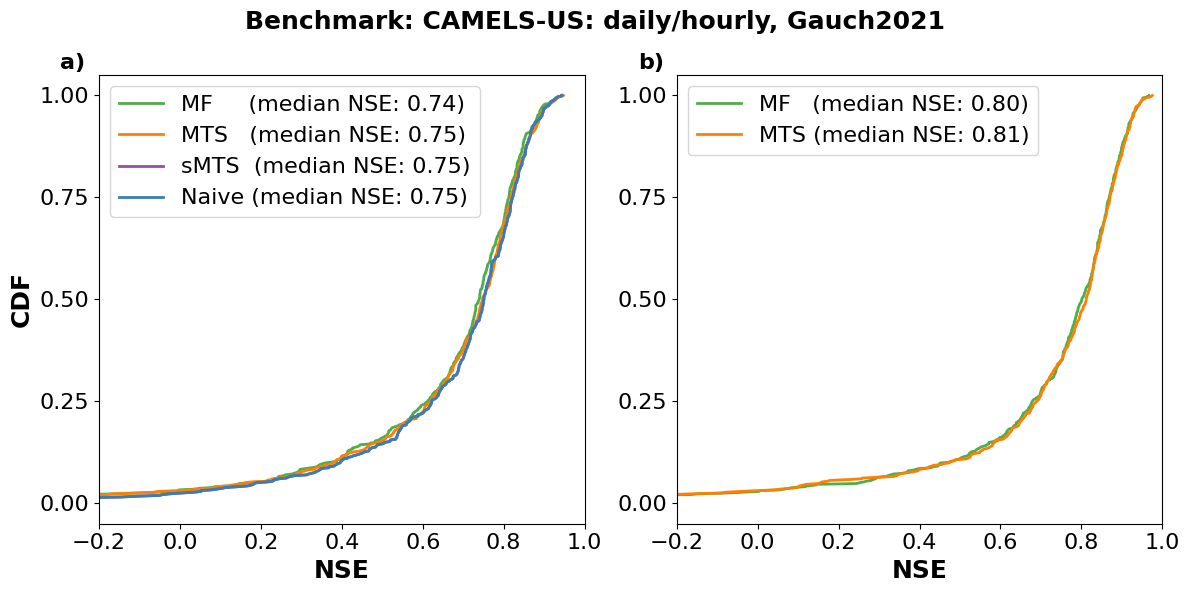

In [8]:
# Create a 2x1 subplot
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# First subplot
axs[0].plot(
    df_NSE_comparison_exp1["LSTM"],
    df_NSE_comparison_exp1["cdf"],
    linewidth=2,
    label=f"MF     (median NSE: {df_NSE_comparison_exp1['LSTM'].median():.2f})",
    color=color_palette["LSTM"],
)
axs[0].plot(
    df_NSE_comparison_exp1["Benchmark_MTS"],
    df_NSE_comparison_exp1["cdf"],
    linewidth=2,
    label=f"MTS   (median NSE: {df_NSE_comparison_exp1['Benchmark_MTS'].median():.2f})",
    color=color_palette["MTS"],
)
axs[0].plot(
    df_NSE_comparison_exp1["Benchmark_sMTS"],
    df_NSE_comparison_exp1["cdf"],
    linewidth=2,
    label=f"sMTS  (median NSE: {df_NSE_comparison_exp1['Benchmark_sMTS'].median():.2f})",
    color=color_palette["sMTS"],
)
axs[0].plot(
    df_NSE_comparison_exp1["Benchmark_Naive"],
    df_NSE_comparison_exp1["cdf"],
    linewidth=2,
    label=f"Naive (median NSE: {df_NSE_comparison_exp1['Benchmark_Naive'].median():.2f})",
    color=color_palette["benchmark"],
)

# Set limits and labels for the first subplot
axs[0].set_xlim(-0.2, 1)
axs[0].set_xlabel("NSE", fontsize=18, fontweight="bold")
axs[0].set_ylabel("CDF", fontsize=18, fontweight="bold")
axs[0].tick_params(axis="both", labelsize=16)  # Set tick label size for both axes
axs[0].set_yticks(np.arange(0, 1.25, 0.25))  # Set y-ticks from 0 to 1 in increments of 0.25
axs[0].legend(loc="upper left", fontsize=16)
axs[0].text(-0.08, 1.05, "a)", transform=axs[0].transAxes, fontsize=16, fontweight="bold", verticalalignment="top")

# Second subplot
axs[1].plot(
    df_NSE_comparison_exp2["LSTM"],
    df_NSE_comparison_exp2["cdf"],
    linewidth=2,
    label=f"MF   (median NSE: {df_NSE_comparison_exp2['LSTM'].median():.2f})",
    color=color_palette["LSTM"],
)
axs[1].plot(
    df_NSE_comparison_exp2["Benchmark_MTS_multipleforcings"],
    df_NSE_comparison_exp2["cdf"],
    linewidth=2,
    label=f"MTS (median NSE: {df_NSE_comparison_exp2['Benchmark_MTS_multipleforcings'].median():.2f})",
    color=color_palette["MTS"],
)

# Set limits and labels for the second subplot
axs[1].set_xlim(-0.2, 1)
axs[1].set_xlabel("NSE", fontsize=18, fontweight="bold")
axs[1].tick_params(axis="both", labelsize=16)  # Set tick label size for both axes
axs[1].set_yticks(np.arange(0, 1.25, 0.25))  # Set y-ticks from 0 to 1 in increments of 0.25
axs[1].legend(loc="upper left", fontsize=16)
axs[1].text(-0.08, 1.05, "b)", transform=axs[1].transAxes, fontsize=16, fontweight="bold", verticalalignment="top")

fig.suptitle("Benchmark: CAMELS-US: daily/hourly, Gauch2021", fontsize=18, fontweight="bold")
# Adjust layout to prevent overlap
plt.tight_layout()
plt.savefig("Benchmark_Gauch2021.png", bbox_inches="tight", pad_inches=0.1, dpi=300)
plt.show()
